In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MovieRecommender(object):
    """Probabilist Matrix Factoriation based movie recommender system
    
    Parameters
    ----------        
    ratings : array-like
        Ratings data in the format: user_id, movie_id, rating

    movie_names : array-like
        The mapping from movie_id to movie name. Row j corresponds to index j of movie_id
        
    sigma : Float
        sigma parameter for matrix factorization
    
    rank : Integer
        rank of matrix for matrix factorization
    
    lmbda : Float
        Lambda parameter for matrix factorization
    """
    def __init__(self, ratings, movie_names, sigma, rank, lmbda):
        
        self.sigma  = sigma
        self.d      = np.identity(rank)
        self.lmbda = lmbda
        
        self.ratings      = ratings
        self.movie_names  = movie_names
        self.users        = ratings.groupby(0)
        self.movies       = ratings.groupby(1)
        self.movie_groups = ratings.groupby(1).groups.keys()
        
        mean = np.zeros(rank)
        cov  = lmbda * self.d
        self.movie_location_matrix = np.random.multivariate_normal(mean, cov, len(self.movie_groups))
        
        self.movie_locations = None
        self.user_locations  = None
    
    def movie_outer_prod(self, movie_id):
        """Calculate the outer product of movie location

        Parameters
        ----------
        movie_id : Integer
            Movie to calculate outer product of
        
        Returns
        ----------
        outer_prod : array-like
            The outer product
        """
        movie_location = self.movie_locations[movie_id]
        outer_prod = np.outer(movie_location, movie_location.T)
        return outer_prod
    
    def update_user(self, user_loc):
        """Update user locations in coordinate ascent

        Parameters
        ----------
        user_loc : array-like
            User information for update
        
        Returns
        ----------
        new_user_loc : array-like
            Updated user locations after coordinate ascent update
        """
        x = np.linalg.inv((self.lmbda*self.sigma*self.d) + np.sum(user_loc[1].apply(self.movie_outer_prod)))
        y = np.dot(self.movie_locations[user_loc[1]], user_loc[2])
        new_user_loc = np.dot(x,y)
        return new_user_loc
    
    def user_outer_prod(self, user_id):
        """Calculate the outer product of user location

        Parameters
        ----------
        user_id : Integer
            User to calculate outer product of
        
        Returns
        ----------
        outer_prod : array-like
            The outer product
        """
        user_location = self.user_locations[user_id]
        outer_prod = np.outer(user_location, user_location.T)
        return outer_prod
    
    def update_movie(self, movie_loc):
        """Update movie locations in coordinate ascent

        Parameters
        ----------
        movie_loc : array-like
            Movie information for update
        
        Returns
        ----------
        new_movie_loc : array-like
            Updated movie locations after coordinate ascent update
        """
        x = np.linalg.inv((self.lmbda*self.sigma*self.d) + np.sum(movie_loc[0].apply(self.user_outer_prod)))
        y = np.dot(self.user_locations[movie_loc[0]], movie_loc[2])
        new_movie_loc = np.dot(x,y)
        return new_movie_loc
    
    def objective_helper(self, loc):
        """ Calculate difference term in objective function calculation

        Parameters
        ----------
        loc : array-like
            rating information
        
        Returns
        ----------
        difference : float
            difference in predicted rating and actual rating
        """
        u = self.user_locations[loc[0]]
        v = self.movie_locations[loc[1]]
        rating = loc[2]
        prediction = np.dot(u, v)
        return rating - prediction
    
    def calculate_objective(self):
        """ Calculate the objective function value

        Returns
        ----------
        objective_value : float
            Objective value based on the current setting of user and movie locations
        """
        user_norm  = (self.lmbda/2) * (self.user_locations.apply(np.linalg.norm).apply(np.square).sum())
        movie_norm = (self.lmbda/2) * (self.movie_locations.apply(np.linalg.norm).apply(np.square).sum())
        difference = (1/(2*self.sigma))*(self.ratings.apply(self.objective_helper, axis = 1).apply(np.square).sum())
        objective_value = (-difference - user_norm - movie_norm)
        return objective_value
    
    def fill_ratings(self, iterations):
        """ MAP inference coordinate ascent algorithm plus calculate objective values
        
        Continuously update the user and movie locations to maximize the probability of the ratings
        
        Parameters
        ----------
        iterations : Integer
            Number of iterations to run the coordinate ascent algorithm
        
        """
        self.objective_values = []
        
        ratings_grouped = pd.Series(pd.DataFrame(self.movie_location_matrix).values.tolist())
        ratings_grouped.index = self.movie_groups
        
        self.movie_locations = ratings_grouped.apply(np.asarray)
        
        for i in range(iterations):
            self.user_locations = self.users.apply(self.update_user)
            self.movie_locations = self.movies.apply(self.update_movie)
            self.objective_values.append(self.calculate_objective())
    
    def predict_single(self, test_point):
        """ Predict a single movie rating

        Parameters
        ----------
        test_point : array-like
            User and movie id to predict rating for
        
        Returns
        ----------
        rating : float
            predicted rating for the movie
        """
        try:
            u = self.user_locations[test_point[0]]
            v = self.movie_locations[test_point[1]]
            rating = np.dot(self.user_locations[test_point[0]], self.movie_locations[test_point[1]])
            return rating
        except Exception:
            pass
    
    def predict(self, test_set):
        """ Predict all ratings

        Parameters
        ----------
        test_set : array-like
            array of User and movie ids to predict ratings for
        
        Returns
        ----------
        rating : array-like
            predicted rating for the entire test set
        """
        predictions = test_set.apply(self.predict_single, axis = 1)
        return predictions
    
    def get_movie_loc(self, movie_name):
        """ Get movie location by name

        Parameters
        ----------
        movie_name : String
            Name of the movie
        
        Returns
        ----------
        movie_loc : array-like
            Movie location
        """
        movie_loc = self.movie_locations[self.movie_names[self.movie_names[0] == movie_name].index[0]]
        return movie_loc
    
    def get_closest(self, movie_name, top, distance_func):
        """ Find the top movies closest to the given movie 

        Parameters
        ----------
        movie_name : String
            Name of the movie
            
        top : Integer
            Number of movies to return
        
        distance_func : Callable
            Distance function to be used
        
        Returns
        ----------
        closest_info : Tuple(Movie Name, Distance)
            Closest movies to the input
        """
        movie_loc = self.get_movie_loc(movie_name)
        closest = self.movie_locations.apply(distance_func, args = [movie_loc]).sort_values()[1:top+1]
        closest_info = movie_names.loc[pd.Series(closest.index)]
        closest_info.rename(index=int, columns={0: 'Movie'}, inplace = True)
        closest_info['Distance'] = closest.values

        return closest_info
        

In [3]:
def RMSE(y_test, predictions):
    """Compute the Root Mean Squared Error between test target and predictions

    Parameters
    ----------
    y_test : array-like
        Test targets
        
    predicted : array-like
        predictions made on the test data
        
    Returns
    ----------
    rmse : float
        Root mean squared error between test targets and predictions
    """    
    rmse = (np.sqrt(((y_test - predictions)**2).mean()))
    return rmse

In [4]:
def distance(a, b):
    """Compute the euclidean distance between two vectors

    Parameters
    ----------
    a : array-like,
        First vector
    
    b : array-like
        Second vector
        
    Returns
    ----------
    dist : float
        Euclidean distance
    """ 
    dist = np.linalg.norm(a-b)
    return dist

In [5]:
# Read in the data
ratings = pd.read_csv('data/ratings.csv', header = None)
ratings_test = pd.read_csv('data/ratings_test.csv', header = None)
movie_names = pd.read_csv('data/movies.txt', sep = "\n", header = None)
movie_names.index += 1 # ids will start from 1

In [6]:
# Matrix factorization parameters
sigma = 0.25
rank = 10
lmbda = 1
iterations = 100

Due to initial randomization which may lead to different result, let's run the movie recommendation model 10 times

In [7]:
recommenders = []
rmse = []
for i in range(10):
    movie_recommender = MovieRecommender(ratings, movie_names, sigma, rank, lmbda)
    movie_recommender.fill_ratings(iterations)
    recommenders.append(movie_recommender)
    predictions = movie_recommender.predict(ratings_test)
    rmse.append(RMSE(ratings_test[2], predictions))

Plot the objective function values for each of the runs

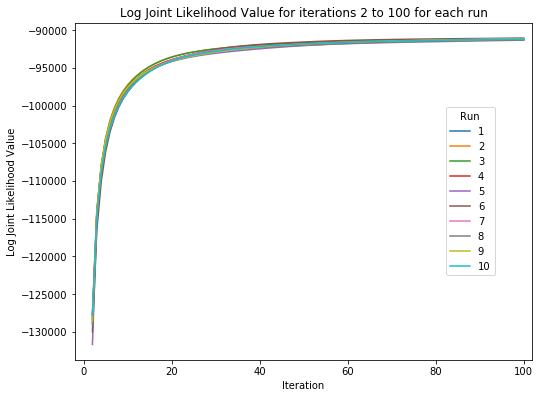

In [8]:
plt.figure(figsize=(8.2,6.2))
for i in range(10):
    plt.plot(list(range(2, 101)), recommenders[i].objective_values[1:], label = str(i+1))
plt.xlim([-2,102])
plt.title('Log Joint Likelihood Value for iterations 2 to 100 for each run')
plt.xlabel('Iteration')
plt.ylabel('Log Joint Likelihood Value')
plt.legend(title = 'Run', loc='center left', bbox_to_anchor=(.80, 0.5));     

Let's display the final objective function value after the 100 iterations and the corresponding RMSE for each of the runs sorted by the objective function value

In [9]:
final_objective_values = [recommender.objective_values[-1] for recommender in recommenders]
objective_rmse = list(zip(final_objective_values, rmse))
final_values_df = pd.DataFrame.from_records(objective_rmse, columns = ['Final Training Objective Value', 'RMSE on Test Set'])
final_values_df.sort_values('Final Training Objective Value', ascending = False, inplace = True)
final_values_df

,Final Training Objective Value,RMSE on Test Set
5,-91054.499699,1.124797
6,-91102.287904,1.112892
8,-91156.847922,1.090640
3,-91171.094281,1.100543
9,-91182.527813,1.115305
2,-91184.442769,1.111443
1,-91217.460980,1.093821
4,-91234.290266,1.112934
0,-91294.678611,1.104935
7,-91331.349368,1.124052


For simplicity we will consider the best recommender to be the one with the lowest objective value

In [10]:
best_recommender = recommenders[final_values_df.index[0]]

Let's see what movies are closest to each other within the best movie recommender. I chose 3 classic movies as examples

In [11]:
best_recommender.get_closest('Star Wars (1977)', 10, distance)

,Movie,Distance
172,"Empire Strikes Back, The (1980)",0.294109
174,Raiders of the Lost Ark (1981),0.578835
181,Return of the Jedi (1983),0.616407
173,"Princess Bride, The (1987)",0.776588
210,Indiana Jones and the Last Crusade (1989),0.823451
166,Manon of the Spring (Manon des sources) (1986),0.829027
613,My Man Godfrey (1936),0.844960
12,"Usual Suspects, The (1995)",0.891699
194,"Sting, The (1973)",0.932501
204,Back to the Future (1985),0.968562


In [12]:
best_recommender.get_closest('My Fair Lady (1964)', 10, distance)

,Movie,Distance
419,Mary Poppins (1964),0.647536
143,"Sound of Music, The (1965)",0.763730
99,Snow White and the Seven Dwarfs (1937),0.906935
629,Victor/Victoria (1982),0.938798
451,Grease (1978),0.961468
283,Emma (1996),0.976705
638,"Return of Martin Guerre, The (Retour de Martin...",0.992302
507,"Streetcar Named Desire, A (1951)",0.996072
132,"Wizard of Oz, The (1939)",1.010904
417,"Parent Trap, The (1961)",1.032347


In [13]:
best_recommender.get_closest('GoodFellas (1990)', 10, distance)

,Movie,Distance
693,Casino (1995),0.503971
646,Once Upon a Time in the West (1969),0.611150
188,Full Metal Jacket (1987),0.616335
504,Bonnie and Clyde (1967),0.706628
177,"Good, The Bad and The Ugly, The (1966)",0.740297
238,Raising Arizona (1987),0.839978
523,Cool Hand Luke (1967),0.868168
180,Apocalypse Now (1979),0.897551
135,2001: A Space Odyssey (1968),0.916734
76,Carlito's Way (1993),0.920744
